In [18]:
# En esta celda se puede probar la funcion de analisis de una imagen

from lib.image import image_data
from lib.analysis import dyssynchrony_analysis
import cv2

# Path completo donde esta la imagen (incluyendo nombre y extencion)
path = './photos_examples/'
photo_name = 'c3f000'
photo = photo_name + '.tif'
# Ancho de la feta a analisar (es un parametro opcional)
slice_width = 5

# Distancia minima en pixeles entre picos
min_dist_between_maxs = 35
# Calibracion del tiempo de cada pixel
calibration = 1

image = cv2.imread(path + photo_name + '.tif')
# Select ROI
fromCenter = False
showCrosshair = False
seleted_parameters = cv2.selectROI(image, fromCenter, showCrosshair)

# Crop image
x_start = int(seleted_parameters[1])
x_end = x_start + int(seleted_parameters[3])
y_start = int(seleted_parameters[0])
y_end = y_start + int(seleted_parameters[2])

cv2.destroyAllWindows()

image = image_data.get_image_data(image)
image = image_data.crop_vertical(image, x_start, x_end)
image = image_data.crop_horizontal(image, y_start, y_end)

results = dyssynchrony_analysis.analyze_image(image, min_dist_between_maxs, calibration, slice_width=slice_width)

[ 4.06611645 -0.00536533]
[ 4.20518934e+00 -3.96295315e-03]
[ 4.35546303e+00 -3.90580540e-03]
[ 4.74254023 -0.0049127 ]
[ 4.99688114e+00 -4.89368030e-03]
[ 5.07871319e+00 -4.44370801e-03]
[ 4.00003127 -0.00722187]
[ 4.04113611e+00 -3.23472697e-03]
[ 4.00617943e+00 -2.85731219e-03]
[ 4.85253511 -0.00618162]
[ 5.518792   -0.00777055]
[ 6.28118633 -0.00920406]
[ 3.97902521 -0.00642245]
[ 4.41031403 -0.00677925]
[ 3.96223789e+00 -2.37423917e-03]
[ 4.91977434 -0.00638604]
[ 5.33269091 -0.00710476]
[ 6.39308217 -0.00943686]
[ 3.9222119 -0.0051993]
[ 4.00757868e+00 -2.89621794e-03]
[ 3.80760753e+00 -1.18070393e-03]
[ 5.06377525 -0.0071782 ]
[ 4.66221828e+00 -4.37032970e-03]
[ 6.05118448 -0.00816055]
[ 3.94520585 -0.00555423]
[ 4.2754934  -0.00583046]
[0.00022514 0.02881761]
[ 5.10878393 -0.00741752]
[ 4.28554277e+00 -2.69373956e-03]
[ 5.5398786  -0.00628992]
[ 3.99838043 -0.00584549]
[ 4.3116646 -0.005848 ]
[0.00025362 0.03068858]
[ 4.90294854 -0.00611284]
[ 3.76120012e+00 -1.77137272e-18]
[ 

/home/leandro/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[ 4.17061214 -0.00766027]
[ 4.34621522 -0.00473447]
[ 4.73967202 -0.00654306]
[ 4.45128592e+00 -3.07532269e-03]
[ 5.17809333 -0.00555742]
[ 5.43802499 -0.00554734]
[ 4.2173664  -0.00887222]
[ 4.567912  -0.0076414]
[ 4.79144782 -0.00694554]
[ 4.74228832e+00 -4.37264354e-03]
[ 4.94356733e+00 -4.59619594e-03]
[ 6.04949242 -0.0076935 ]
[ 4.11331105 -0.00596974]
[ 4.54807607 -0.0080737 ]
[ 4.56289518 -0.005275  ]
[ 4.23897666e+00 -1.54372419e-03]
[ 5.7505553  -0.00660535]
[ 4.06715195 -0.00493902]
[ 4.49906656 -0.00802832]
[ 4.31922706e+00 -3.53040653e-03]
[ 5.44950788 -0.00793264]
[ 4.78487491e+00 -3.84208727e-03]
[ 5.32527975e+00 -5.17365503e-03]
[ 4.05559388 -0.00490669]
[ 4.3559349  -0.00678595]
[ 4.21137337e+00 -2.66496997e-03]
[ 5.03015019 -0.00601527]
[ 4.1569760e+00 -1.1354221e-03]
[ 4.05375775 -0.00501271]
[ 4.23074532 -0.00554433]
[ 4.30072000e+00 -3.27089075e-03]
[ 4.98307424 -0.00604521]
[ 4.06887660e+00 -8.70518948e-04]
[ 4.90371914e+00 -3.95758420e-03]
[ 4.11535186 -0.00671316

In [19]:
jasonGenerator(path,results,photo_name)

In [ ]:
dic = jasonReader(path + 'analysis_result_' + photo_name + '.json')
slicesParser_amplitudes(dic)

In [ ]:
print(results['image']['max_peaks_positions'])
for i in range(0,len(results['slices'])):
    array = results['slices'][i]['max_peaks_positions']
    print(i,array)

In [ ]:
import matplotlib.pyplot as plt

for i in range(0,len(results['slices'])):
    array = results['slices'][i]['intensities']
    plt.plot(array) # plotting by columns
    plt.show()

# PRUEBA ANALISIS 

In [ ]:
# En esta celda se puede probar la funcion de analisis todas las imagenes .tif en un directorio
import os
from lib.image import image_data
from lib.analysis import dyssynchrony_analysis
import cv2

# Ancho de la feta a analisar (es un parametro opcional)
slice_width = 5

# Distancia minima en pixeles entre picos
min_dist_between_maxs = 200

# Calibracion del tiempo de cada pixel
calibration = 3.1

# Path donde estan las imagenes
path = "C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/1 Hz/"

images_paths = [ f'{path}/{file}' for file in os.listdir(path) if file.endswith(".tif") ]
images = [ cv2.imread(image_path) for image_path in images_paths ]

In [ ]:
fromCenter = False
showCrosshair = False

#Tomamos la primer imagen para seleccionar el recorte elegido el resto de las imagenes se van a recortar igual
seleted_parameters = cv2.selectROI(images[0], fromCenter, showCrosshair)

# Crop image
x_start = int(seleted_parameters[1])
x_end = x_start + int(seleted_parameters[3])
y_start = int(seleted_parameters[0])
y_end = y_start + int(seleted_parameters[2])

cv2.destroyAllWindows()

In [ ]:
images = [ image_data.get_image_data(image) for image in images ]
images = [ image_data.crop_vertical(image, x_start, x_end) for image in images ]
images = [ image_data.crop_horizontal(image, y_start, y_end) for image in images ]

In [ ]:
results = [(dyssynchrony_analysis.analyze_image(image, min_dist_between_maxs, calibration, slice_width=5), print ('Done')) for image in images]

# Analisis de datos
Notas: 
- Image corresponde al análisis de toda la célula y slices corresponde a fetas de esa imagen
- intensidades es el valor que resulta de comprimir (sumando) la matriz con las coordenadas de x,y,z de los pixeles 
- max_peaks_pos es la index de en la lista de intensidades 
- max_peaks_intensities el valor de intensidad que se corresponde con el pico en la posicion analoga de max_peaks_pos

In [6]:
#Imports
import json
import numpy as np
import pandas as pd

In [7]:
#encodes a dictionary into a jason
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


def jasonGenerator(path,results,photo_name):
    """ Generates a .jason file in the path given folder from the a dictionary """
    with open(path + '/analysis_result_' + photo_name + '.json',"w") as miarch:
        miarch.write(json.dumps(results, cls=NumpyEncoder))

In [8]:
def jasonReader(path):
    """ Reads the .jason generated with jasonGenartor the given path"""
    with open(path,'r') as miarch:
        loaded_dict = json.loads(miarch.read())
    return loaded_dict

In [9]:
def slicesParser_max_peaksI(dictres):
#extract all the slices data
    allSlices = dictres['slices']
    #seting columns names
    column_names = ['transient' + str(x) for x in range(0,len(allSlices[0]['max_peaks_intensities']))]    
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    for i in range(0,len(allSlices)):
        df_sum.loc[i] = allSlices[i]['max_peaks_intensities'][0:] 
    return df_sum

In [10]:
def slicesParser_halfpeakstime(dictres):
    #extract all the slices data
    allSlices = dictres['slices']
    
    #seting columns names
    column_names = ['transient' + str(x+1) for x in range(0,len(allSlices[0]['times_to_half_peaks']))]
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    #populating the dataframe
    for i in range(0,len(allSlices)):
        df_sum.loc[i+1] = allSlices[i]['times_to_half_peaks']
    return df_sum

In [11]:
def slicesParser_amplitudes(dictres):
    #extract all the slices data
    allSlices = dictres['slices']
    #seting columns names
    column_names = ['transient' + str(x+1) for x in range(0,len(allSlices[0]['amplitudes']))]
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    #populating the dataframe
    for i in range(0,len(allSlices)):
        df_sum.loc[i+1] = allSlices[i]['amplitudes']

    return df_sum

In [12]:
def slicesParser_min_peaksI(dictres):
    #extract all the slices data
    allSlices = dictres['slices']
    #seting columns names
    column_names = ['transient' + str(x+1) for x in range(0,len(allSlices[0]['min_peaks_intensities']))]
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    #populating the dataframe
    for i in range(0,len(allSlices)):
        df_sum.loc[i+1] = allSlices[i]['min_peaks_intensities']

    return df_sum

In [13]:
def slicesParser_peaktime(dictres):
    #extract all the slices data
    allSlices = dictres['slices']

    #seting columns names
    column_names = ['transient' + str(x+1) for x in range(0,len(allSlices[0]['times_to_peaks']))]
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    #populating the dataframe
    for i in range(0,len(allSlices)):
        df_sum.loc[i+1] = allSlices[i]['times_to_peaks']

    return df_sum

In [14]:
def slicesParser_tau(dictres):
    #extract all the slices data
    allSlices = dictres['slices']
    #seting columns names
    column_names = ['transient' + str(x+1) for x in range(0,len(allSlices[0]['tau_s']))]
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    #populating the dataframe
    for i in range(0,len(allSlices)):
        df_sum.loc[i+1] = allSlices[i]['tau_s']

    return df_sum

In [15]:
def BasicStasts(df):
    if df.empty == False:
        return df.astype('int').describe()

In [16]:
def amplitudes_ratio(df):
    df_alt = pd.DataFrame()
    for i in range(0,len(list(df))-1):
        name = 'ratio' + str(i+1) +'-' + str(i)
        df_alt[name] = df[list(df)[i+1]]/df[list(df)[i]]
    return df_alt

In [ ]:
# path = '/home/leandro/Documentos/Analisis_de_imagenes/CardiAP/DesktopApp/photos_examples/'
photo_name = 'c1d000'
photo = photo_name + '.tif'

In [ ]:
loaded_dict = jasonReader(path)

In [ ]:
BasicStasts(slicesParser_max_peaksI(path))

In [ ]:
amplitudes_ratio(slicesParser_amplitudes(path)).std()

In [ ]:
amp_mean = slicesParser_amplitudes(path).mean()
for i in range(0,len(amp_mean)-1):
    AR_ind = (1- (amp_mean[i+1])/amp_mean[i])
    print (AR_ind)

In [ ]:
slicesParser_min_peaksI(path).head(2)

In [ ]:
slicesParser_tau(path).head()

In [ ]:
def discordance_index(path):
    DIs = pd.DataFrame()
    for j in range (1, len(slicesParser_amplitudes(path).columns)):
        rel_diff = []
        for i in range (0, len (slicesParser_amplitudes(path))):
            T1 = list(slicesParser_amplitudes(path)['transient'+str(j)])[i]
            T2 = list(slicesParser_amplitudes(path)['transient'+str(j+1)])[i]
            rel_diff.append((T1-T2)/max(T1,T2))
        DIs[j] = rel_diff
    return DIs
def alternance_ratio(path):
    T1_mean = float(slicesParser_amplitudes(path)['transient1'].mean())
    T2_mean = float(slicesParser_amplitudes(path)['transient2'].mean())
    AR = (abs(T1_mean-T2_mean))/max(T1_mean, T2_mean)
    return AR

In [ ]:
import os

DI_list = []
path = 'C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/Luis/jsons/'
jsons_list = os.listdir(path)
for file in jsons_list:
    path_file = path + file
    dic = jasonReader(path_file)
    print (file)
    DI_list.append(discordance_index(dic))
print('Done')

In [ ]:
file = []
for index in range(0,len(DI_list)):
    file.append([jsons_list[index], (DI_list[index]).std().mean()])

In [ ]:
import csv
import pandas as pd    

df = pd.DataFrame(file, columns= ['photo_name','DI'])
df.to_csv(path + 'discordances_indexes.csv', sep='\t')

In [ ]:
arch_defectuosos = []
for i in list_archs:
    dic = jasonReader(i)
    try:
        slicesParser_max_peaksI(dic)
    except:
        arch_defectuosos.append(i)

In [ ]:
arch_defectuosos

In [ ]:
import os

AR_list = []
path = 'C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/Luis/jsons/'
jsons_list = os.listdir(path)
for file in jsons_list:
    path_file = path + file
    dic = jasonReader(path_file)
    T1_mean = dic['image']['amplitudes'][0]
    T2_mean = dic['image']['amplitudes'][1]
    AR_list.append([file, (abs(T1_mean-T2_mean))/max(T1_mean, T2_mean)])
print('Done')

In [ ]:
import csv
import pandas as pd    

df = pd.DataFrame(AR_list, columns= ['photo_name','AR'])
df.to_csv(path + 'alternance_ratio.csv', sep='\t')

In [ ]:
disc_index = pd.read_csv('C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/Luis/discordances_indexes.csv', encoding='utf-8', sep='\t')

In [ ]:
from scipy.stats import ttest_ind, ttest_ind_from_stats
t, p = ttest_ind(DI_5hz_C['DI'], DI_5hz_D['DI'], equal_var=False)
p

In [ ]:
import os

tau_list = []
path = 'C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/Luis/jsons/'
jsons_list = os.listdir(path)
for file in jsons_list:
    path_file = path + file
    dic = jasonReader(path_file)
    taus = slicesParser_tau(dic)
    tau_list.append(taus)
print('Done')

In [ ]:
tau_list[-1].mean().mean()

In [ ]:
tau_list = []
path = 'C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/Luis/jsons/'
jsons_list = os.listdir(path)
for file in jsons_list:
    path_file = path + file
    dic = jasonReader(path_file)
    taus = dic['image']['tau_s']
    tau_list.append([file,sum(taus)/len(taus),slicesParser_tau(dic).mean().mean()])

In [ ]:
import csv
import pandas as pd    

df = pd.DataFrame(tau_list, columns= ['photo_name','tau_wc', 'tau_slices'])
df.to_csv(path + 'tau.csv', sep='\t')

{'N': 140.28018054265752, 'tau': 214.94389392143512}
[[Variables]]
    N:    10.0000000 (init = 10)
    tau:  1.00000000 (init = 1)


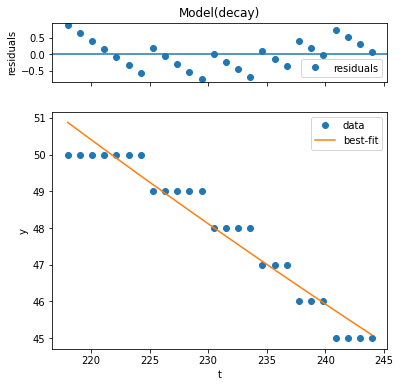

In [30]:
import numpy as np
from pandas import Series

from lmfit import Model, Parameter, report_fit

def decay(t, N, tau):
    return N*np.exp(-t/tau)

t = np.linspace(218, 244, num=26)
data = [50, 50, 50, 50, 50, 50, 50, 49, 49, 49, 49, 49, 48, 48, 48, 48, 47, 47, 47, 46, 46, 46, 45, 45, 45, 45]

model = Model(decay, independent_vars=['t'])
result = model.fit(data, t=t, N=10, tau=150)
result.plot()
print(result.values)

result = model.fit(data, t=t,
                   N=Parameter('N', value=10),
                   tau=Parameter('tau', value=1))
report_fit(result.params)